Importing necessary packages

In [332]:
# Importing the pandas library for data manipulation and analysis
import pandas as pd

# Importing the matplotlib library for creating visualizations
import matplotlib.pyplot as plt

# Importing the backtrader library for backtesting trading strategies
import backtrader as bt

# Importing the numpy library for numerical computing
import numpy as np

# Importing matrix, solvers, and blas from cvxopt library for convex optimization
from cvxopt import matrix, solvers, blas

# Importing the tabulate library for creating tables
from tabulate import tabulate

# Importing the datetime module to work with dates and times
import datetime

# Importing the matplotlib library again (this line is redundant)
import matplotlib.pyplot as plt

# Importing the cvxopt library for convex optimization 
import cvxopt as opt

# Importing quantStats for quantitative financial analysis
import quantstats as qs

import math

Notebook Settings

In [333]:
# Setting the maximum number of columns to display in pandas to None, which means all columns will be displayed
pd.set_option('display.max_columns', None)

# Setting the maximum number of rows to display in pandas to None, which means all rows will be displayed
pd.set_option('display.max_rows', None)

# Using the magic command %matplotlib inline to display matplotlib plots inline in a Jupyter notebook
%matplotlib inline

# Setting the random seed for numpy to 42 for reproducibility
np.random.seed(42)

# Setting the 'show_progress' option for solvers in cvxopt library to False, which means no progress will be shown while solving
solvers.options['show_progress'] = False


Load the data

In [334]:
# Reading a CSV file named 'prices.csv' into a pandas DataFrame
df = pd.read_csv('prices.csv')

# Converting the 'date' column to a datetime object with the specified format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Getting the minimum and maximum dates in the 'date' column
start_date = df['date'].min()
end_date = df['date'].max()

# store starting dates for each ticker
start_dates = df.groupby('ticker')['date'].min()

# Creating a DataFrame with all combinations of tickers and dates
tickers = df['ticker'].unique()
dates = pd.date_range(start=start_date, end=end_date, freq='D')
index = pd.MultiIndex.from_product([tickers, dates], names=['ticker', 'date'])
dummy_df = pd.DataFrame(index=index).reset_index()

# Merging the dummy DataFrame with the original DataFrame on the 'ticker' and 'date' columns
merged_df = pd.merge(dummy_df, df, on=['ticker', 'date'], how='left')

# Forward filling missing values in the 'close' column with the next available value within each group of 'ticker'
merged_df['close'] = merged_df.groupby('ticker')['close'].fillna(method='bfill')

# Backward filling remaining missing values in the 'close' column with the previous available value within each group of 'ticker'
merged_df['close'] = merged_df.groupby('ticker')['close'].fillna(method='ffill')

merged_df['open'] = merged_df['close']
merged_df['high']=merged_df['close']
merged_df['low']=merged_df['close']

# Updating the original DataFrame with the merged DataFrame
df = merged_df

# Converting the 'date' column to a datetime object with the specified format again (this line is redundant)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Setting the 'date' column as the index of the DataFrame
df = df.set_index('date')

# Printing the first 5 rows of the DataFrame using tabulate library for pretty printing
print(tabulate(df.head(), headers='keys', tablefmt='psql'))

# Printing the minimum and maximum dates in the index of the DataFrame
print(f'Records from {df.index.min()} to {df.index.max()}')

# Printing the unique values in the 'ticker' column of the DataFrame
print(f'Tickers: {df.ticker.unique()}')

#find the highest one day % change for each ticker
df['pct_change'] = df.groupby('ticker')['close'].pct_change()
# print the max
print(df.groupby('ticker')['pct_change'].max())

+---------------------+----------+---------+---------+---------+---------+
| date                | ticker   |    open |    high |     low |   close |
|---------------------+----------+---------+---------+---------+---------|
| 2010-01-04 00:00:00 | AXISBANK | 140.712 | 140.712 | 140.712 | 140.712 |
| 2010-01-05 00:00:00 | AXISBANK | 143.648 | 143.648 | 143.648 | 143.648 |
| 2010-01-06 00:00:00 | AXISBANK | 141.237 | 141.237 | 141.237 | 141.237 |
| 2010-01-07 00:00:00 | AXISBANK | 142.237 | 142.237 | 142.237 | 142.237 |
| 2010-01-08 00:00:00 | AXISBANK | 144.095 | 144.095 | 144.095 | 144.095 |
+---------------------+----------+---------+---------+---------+---------+
Records from 2010-01-04 00:00:00 to 2020-06-15 00:00:00
Tickers: ['AXISBANK' 'BAJAJFINSV' 'BAJAJHLDNG' 'BAJFINANCE' 'BANDHANBNK'
 'BANKBARODA' 'GICRE' 'HDFC' 'HDFCAMC' 'HDFCBANK' 'HDFCLIFE' 'IBULHSGFIN'
 'ICICIBANK' 'ICICIGI' 'ICICIPRULI' 'INDUSINDBK' 'KOTAKBANK' 'L&TFH'
 'NIACL' 'PEL' 'PFC' 'PNB' 'SBILIFE' 'SBIN' 'SRTRANSF

Plot of Covariance matrix

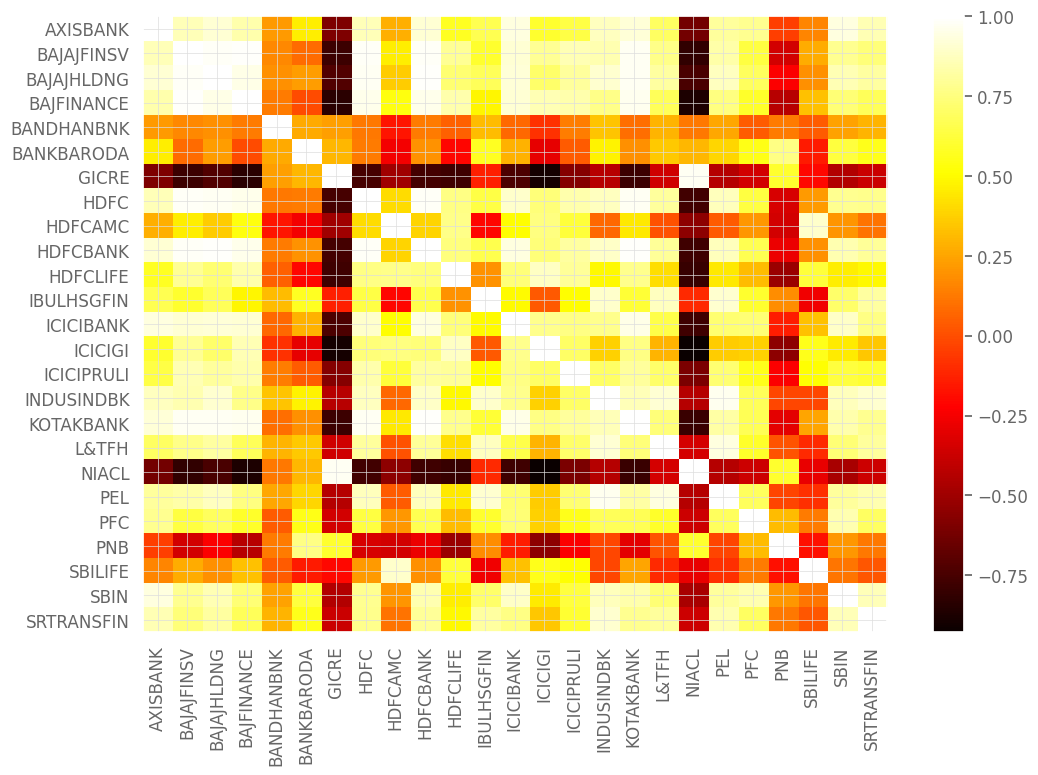

In [335]:
# Creating a dictionary of DataFrames, one for each unique value in the 'ticker' column of the original DataFrame
dfs = {ticker: df[df['ticker'] == ticker].copy() for ticker in df['ticker'].unique()}

# Creating a pivot table from the original DataFrame with 'date' as the index, 'ticker' as the columns, and 'close' as the values
close_df = df.pivot_table(index='date', columns='ticker', values='close')

# Calculating the Pearson correlation matrix of the closing prices of all tickers with each other
corr_df = close_df.corr(method='pearson')

# Creating a figure with a specified size
plt.figure(figsize=(12, 8))

# Displaying the correlation matrix as an image with a 'hot' colormap and no interpolation
plt.imshow(corr_df.values, cmap='hot', interpolation='none', aspect='auto')

# Adding a colorbar to the figure
plt.colorbar()

# Setting the x-ticks to be the column names of the correlation matrix and rotating them vertically
plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation='vertical')

# Setting the y-ticks to be the column names of the correlation matrix
plt.yticks(range(len(corr_df.columns)), corr_df.columns)

# Displaying the figure
plt.show()


Plot of closing prices of all tickers

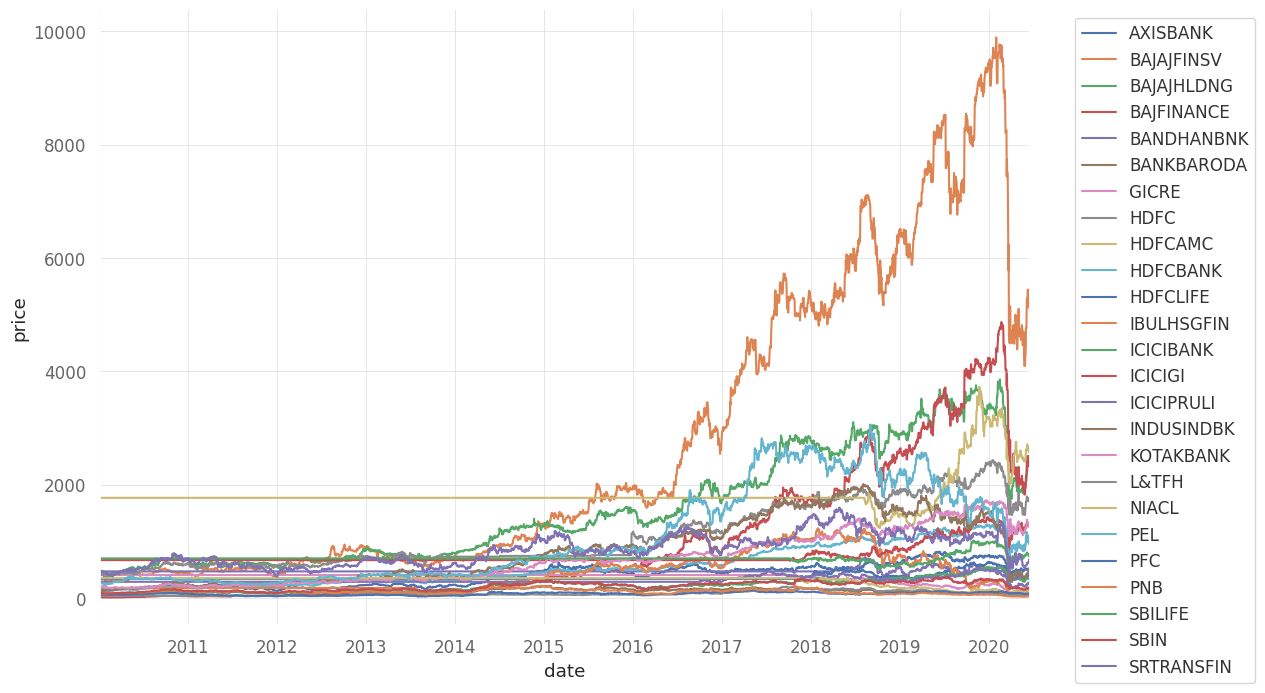

In [336]:
# Visualizing the closing prices of all tickers using the plot method of the pivot table DataFrame
close_df.plot(figsize=(12, 8))

# Adding a legend to the figure and positioning it outside the plot area to the upper left
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

# Adding a label to the y-axis
plt.ylabel('price')

# Displaying the figure
plt.show()


# Mean Variance Optimization Strategy

In [337]:
# Defining a class named 'MeanVarOpt' that inherits from the 'bt.Strategy' class
class MeanVarOpt(bt.Strategy):
    # Defining the strategy parameters as a tuple of tuples
    params = (
        ('sma', 200),  # Simple moving average period
        ('lookback', 500),  # Lookback period for calculating returns
        ('rebalance_day', 1),  # Day of the month to rebalance the portfolio
        ('risk_tolerance', 1),  # Risk tolerance parameter
        ('alpha',0.95)  # maximum weight for a single stock
    )
    
    # Defining the __init__ method to initialize the instance variables
    def __init__(self):
        # Initializing instance variables to store simple moving averages and closing prices over simple moving averages
        self.SMA = []
        self.close_over_sma = []
        
        # Initializing the portfolio weights to be equal for all assets and scaled by the risk tolerance parameter
        # self.weights = np.ones(len(self.datas)) / len(self.datas)
        
        # Looping over each data feed and calculating its simple moving average using the 'bt.indicators.SMA' class
        for i, d in enumerate(self.datas):
            self.SMA.append(bt.indicators.SMA(d.close, period=self.params.sma))
        
        # Initializing an instance variable to store the selected stocks
        self.selected_stocks = []
        
        # Adding all tickers to the list of selected stocks
        for i, d in enumerate(self.datas):
            self.selected_stocks.append(d._name)

    # Defining a method named 'log' to log messages with timestamps (currently not used)
    def log(self, txt):
        dt = self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} | {txt}')

    # Defining the 'stop' method to execute when the backtesting is finished
    def stop(self):
        # Looping over each data feed and closing any open position
        for i, d in enumerate(self.datas):
            self.close(data=d)
    
    # Defining a method named 'calculate_portfolio_weights' to calculate the optimal portfolio weights using mean-variance optimization
    def calculate_portfolio_weights(self):
        # Checking if there is enough data to calculate returns
        if len(self.datas[0]) < self.params.lookback:
            return np.zeros(len(self.datas))
        
        # Initializing variables to store prices and returns for each data feed
        n_portfolios = len(self.datas)
        prices = np.zeros((n_portfolios, self.params.lookback))
        returns = np.zeros((n_portfolios, self.params.lookback))
        
        # Looping over each data feed and getting its closing prices and returns
        for i, d in enumerate(self.datas):
            prices[i, :] = d.close.get(size=self.params.lookback)
            returns[i, 1:] = np.diff(prices[i, :]) / prices[i, :-1]
        
        # Converting the returns array to a matrix
        returns = np.asmatrix(returns)
        
        # Defining the number of portfolios on the efficient frontier and their expected returns
        N = 100
        mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
        
        # Calculating the covariance matrix of returns and converting it to a cvxopt matrix
        S = opt.matrix(np.cov(returns))
        
        # Calculating the mean returns and converting it to a cvxopt matrix
        pbar = opt.matrix(np.mean(returns, axis=1))
        
        # Creating constraint matrices for quadratic programming
        G = -opt.matrix(np.eye(n_portfolios))   # negative n x n identity matrix
        h = opt.matrix(0.0, (n_portfolios ,1))
        A = opt.matrix(1.0, (1, n_portfolios))
        b = opt.matrix(1.0)
        
        # Calculating efficient frontier weights using quadratic programming for each expected return on the frontier
        portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
        
        # Calculating risks and returns for frontier portfolios
        returns = [blas.dot(pbar, x) for x in portfolios]
        risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]

        risks = np.array(risks)
        risks = risks * (1/self.params.risk_tolerance)
        
        # Calculating the 2nd degree polynomial of the frontier curve
        m1 = np.polyfit(returns, risks, 2)
        
        # Calculating the expected return that minimizes portfolio variance (i.e., risk)
        x1 = np.sqrt(m1[2] / m1[0])
        
        # Calculating the optimal portfolio weights using quadratic programming
        wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
        
        # Updating the instance variable with the calculated weights and normalizing them to sum to 1
        weights = np.asarray(wt)
        weights[weights < 0] = 0

        # if stock is not selected set weight to 0
        for i, d in enumerate(self.datas):
            if(d._name not in self.selected_stocks):
                weights[i] = 0

        if(np.sum(weights) == 0):
            return weights
        
        weights /= np.sum(weights)

        return weights
        

    # Defining the 'next' method to execute on each iteration of the backtesting loop
    def next(self):
        # Getting the current date of the first data feed
        curr_date = self.data.datetime.date(0)
        
        # Checking if the current day is the rebalance day
        if curr_date.day != self.params.rebalance_day:
            return
        
        # Logging the current date
        self.log(f'Processing {curr_date}')
        
        # Resetting the list of selected stocks
        self.selected_stocks = []
        
        # Looping over each data feed and checking if its current closing price is above its simple moving average
        for i, d in enumerate(self.datas):
            if d.close[0] > self.SMA[i][0]:
                # Adding the ticker to the list of selected stocks
                self.selected_stocks.append(d._name)
        
        # Logging the selected stocks
        self.log(f'Selected stocks: {self.selected_stocks}')
        
        # Calculating the optimal portfolio weights
        weights=self.calculate_portfolio_weights()

        for i, d in enumerate(self.datas):
            self.close(data=d)
        

        # find the current portfolio value
        portfolio_value = self.broker.getvalue()
        self.log(f'Portfolio value: {portfolio_value}')

        # Looping over each data feed and placing orders according to the calculated weights
        for i, d in enumerate(self.datas):
            if  start_dates[d._name] < curr_date - datetime.timedelta(days=self.params.lookback):
                # Placing an order to adjust the position size to match the calculated weight
                self.log(f'Ordering {d._name} with weight {weights[i]}')

                if weights[i] > self.params.alpha:
                    weights[i] = self.params.alpha
                
                no_of_stocks=portfolio_value*weights[i]/d.close[0]

                # round down
                no_of_stocks = int(no_of_stocks)
                self.buy(data=d, size=no_of_stocks)
                
                # log the quantity of shares bought
                self.log(f'Quantity of shares bought: {self.getposition(d).size}')


In [338]:
# Creating an instance of the 'bt.Cerebro' class
cb = bt.Cerebro()

# Adding the 'MeanVarOpt' strategy to the Cerebro instance
cb.addstrategy(MeanVarOpt)

# Setting the starting portfolio value
starting_portfolio_value = 10000000.0
cb.broker.setcash(starting_portfolio_value)

# Looping over each unique value in the 'ticker' column of the DataFrame
for ticker in df['ticker'].unique():
    # Creating a new DataFrame with only rows where the 'ticker' column is equal to the current ticker
    df1 = df[df['ticker'] == ticker]
    
    # Creating a data feed from the new DataFrame using the 'bt.feeds.PandasData' class
    df_feed = bt.feeds.PandasData(dataname=df1,
                                  open='open',
                                  close='close',
                                  high='high',
                                  low='low',
                                  volume=None,
                                  openinterest=None,
                                  datetime=None,
                                  fromdate=datetime.datetime(2010, 1, 1),
                                  todate=datetime.datetime(2020, 12, 31))
    
    # Adding the data feed to the Cerebro instance with a name equal to the current ticker
    cb.adddata(df_feed, name=ticker)

# add analyzers
cb.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

# Running the backtesting using the Cerebro instance
results=cb.run()


2010-08-01 | Processing 2010-08-01
2010-08-01 | Selected stocks: ['AXISBANK', 'BAJAJFINSV', 'BAJAJHLDNG', 'BAJFINANCE', 'BANKBARODA', 'HDFC', 'HDFCBANK', 'ICICIBANK', 'INDUSINDBK', 'KOTAKBANK', 'PEL', 'PFC', 'PNB', 'SBIN', 'SRTRANSFIN']
2010-08-01 | Portfolio value: 10000000.0
2010-09-01 | Processing 2010-09-01
2010-09-01 | Selected stocks: ['AXISBANK', 'BAJAJFINSV', 'BAJAJHLDNG', 'BAJFINANCE', 'BANKBARODA', 'HDFC', 'HDFCBANK', 'ICICIBANK', 'INDUSINDBK', 'KOTAKBANK', 'PEL', 'PFC', 'PNB', 'SBIN', 'SRTRANSFIN']
2010-09-01 | Portfolio value: 10000000.0
2010-10-01 | Processing 2010-10-01
2010-10-01 | Selected stocks: ['AXISBANK', 'BAJAJFINSV', 'BAJAJHLDNG', 'BAJFINANCE', 'BANKBARODA', 'HDFC', 'HDFCBANK', 'ICICIBANK', 'INDUSINDBK', 'KOTAKBANK', 'PEL', 'PFC', 'PNB', 'SBIN', 'SRTRANSFIN']
2010-10-01 | Portfolio value: 10000000.0
2010-11-01 | Processing 2010-11-01
2010-11-01 | Selected stocks: ['AXISBANK', 'BAJAJFINSV', 'BAJAJHLDNG', 'BAJFINANCE', 'BANKBARODA', 'HDFC', 'HDFCBANK', 'ICICIBANK',

/home/sirbruce/anaconda3/envs/won/lib/python3.7/site-packages/ipykernel_launcher.py:151: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


2010-12-01 | Processing 2010-12-01
2010-12-01 | Selected stocks: ['AXISBANK', 'BAJAJFINSV', 'BAJAJHLDNG', 'BAJFINANCE', 'BANKBARODA', 'HDFC', 'HDFCBANK', 'ICICIBANK', 'INDUSINDBK', 'KOTAKBANK', 'PFC', 'PNB', 'SBIN', 'SRTRANSFIN']
2010-12-01 | Portfolio value: 10000000.0
2011-01-01 | Processing 2011-01-01
2011-01-01 | Selected stocks: ['BAJAJFINSV', 'BAJAJHLDNG', 'BAJFINANCE', 'BANKBARODA', 'HDFC', 'HDFCBANK', 'ICICIBANK', 'INDUSINDBK', 'KOTAKBANK', 'PNB', 'SRTRANSFIN']
2011-01-01 | Portfolio value: 10000000.0
2011-02-01 | Processing 2011-02-01
2011-02-01 | Selected stocks: []
2011-02-01 | Portfolio value: 10000000.0
2011-03-01 | Processing 2011-03-01
2011-03-01 | Selected stocks: ['SRTRANSFIN']
2011-03-01 | Portfolio value: 10000000.0
2011-04-01 | Processing 2011-04-01
2011-04-01 | Selected stocks: ['AXISBANK', 'BAJAJFINSV', 'BANKBARODA', 'HDFC', 'HDFCBANK', 'ICICIBANK', 'INDUSINDBK', 'KOTAKBANK', 'SRTRANSFIN']
2011-04-01 | Portfolio value: 10000000.0
2011-05-01 | Processing 2011-05-01

In [339]:
# Getting the final portfolio value from the broker in the Cerebro instance
final_portfolio_value = cb.broker.getvalue()

# Printing the starting and final portfolio values
print(f'Starting Portfolio Value: {starting_portfolio_value:.2f}')
print(f'Final Portfolio Value: {final_portfolio_value:.2f}')

# Calculating and printing the absolute and percentage profit
print(f'Profit: {final_portfolio_value - starting_portfolio_value:.2f}')
print(f'% Profit: {(final_portfolio_value - starting_portfolio_value) / starting_portfolio_value * 100:.2f}%')


Starting Portfolio Value: 10000000.00
Final Portfolio Value: 89197054.04
Profit: 79197054.04
% Profit: 791.97%


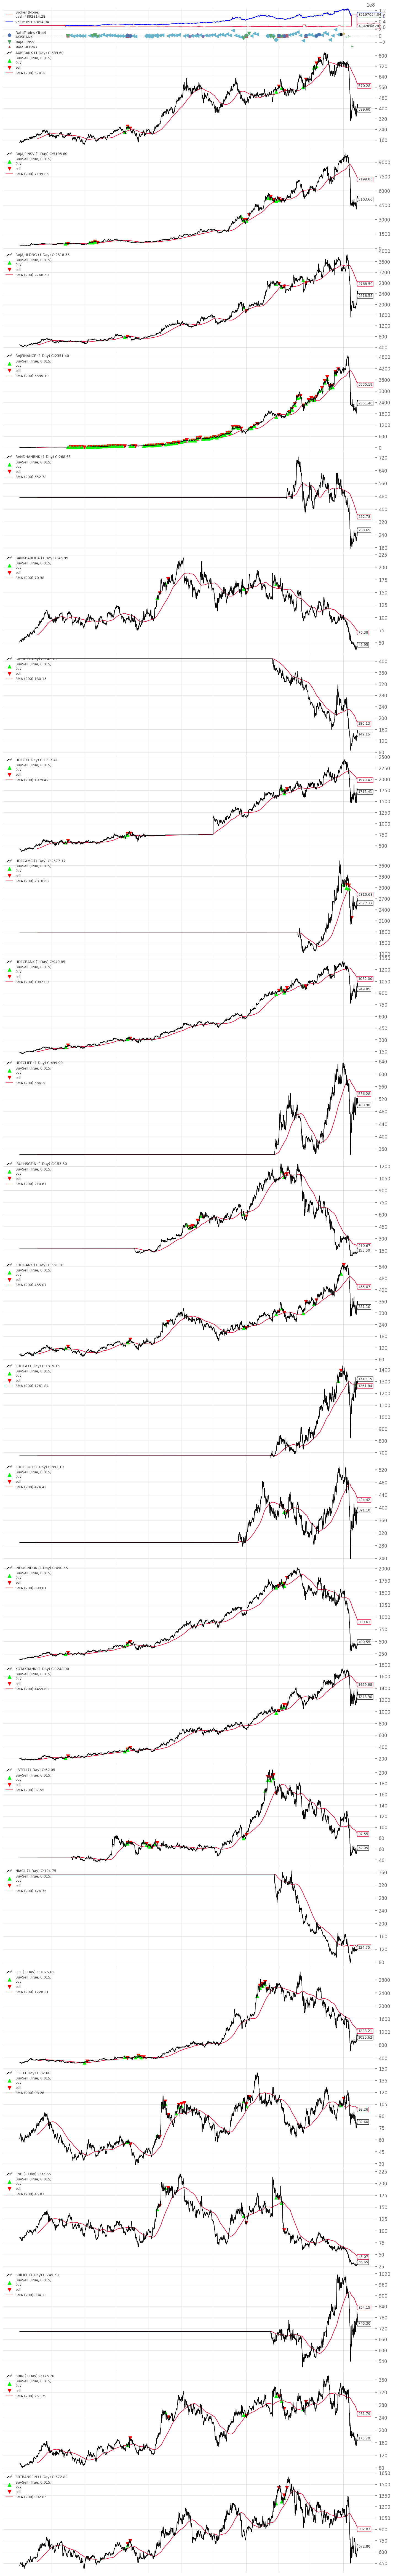

[[<Figure size 1500x10000 with 27 Axes>]]

In [340]:
%matplotlib inline
# Setting the default figure size for matplotlib
plt.rcParams['figure.figsize'] = [15, 100]

# Updating the default font size for matplotlib
plt.rcParams.update({'font.size': 12})

# Plotting the results of the backtesting using the 'plot' method of the Cerebro instance
cb.plot(iplot=False, volume=False)


                           Strategy
-------------------------  ----------
Start Period               2010-01-04
End Period                 2020-06-15
Risk-Free Rate             0.0%
Time in Market             58.0%

Cumulative Return          791.97%
CAGR﹪                     23.29%

Sharpe                     0.72
Prob. Sharpe Ratio         99.76%
Smart Sharpe               0.7
Sortino                    1.1
Smart Sortino              1.08
Sortino/√2                 0.78
Smart Sortino/√2           0.76
Omega                      1.19

Max Drawdown               -38.3%
Longest DD Days            428
Volatility (ann.)          24.17%
Calmar                     0.61
Skew                       0.51
Kurtosis                   12.16

Expected Daily %           0.06%
Expected Monthly %         1.75%
Expected Yearly %          22.01%
Kelly Criterion            7.99%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.44%
Expected Shortfall (cVaR)  -2.44%

Max Consecutive Wins       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-21,2020-03-24,2020-06-15,115,-38.301821,-37.654295
2,2017-06-13,2018-03-17,2018-08-15,428,-37.415154,-36.936268
3,2016-09-09,2016-12-22,2017-04-08,211,-31.012279,-29.717565
4,2013-07-16,2014-03-20,2014-09-06,417,-29.284526,-28.557766
5,2018-08-30,2018-10-26,2019-05-17,260,-26.830023,-25.974858


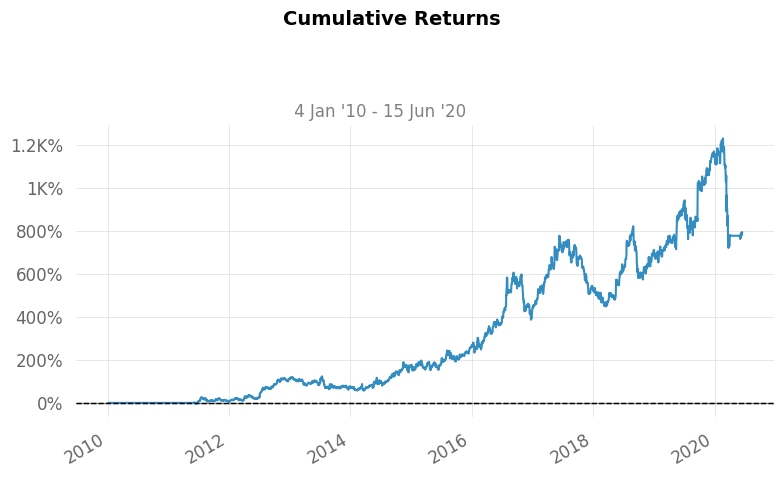

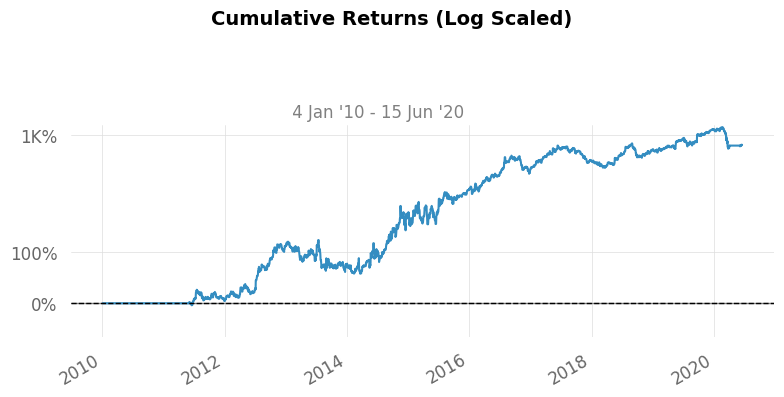

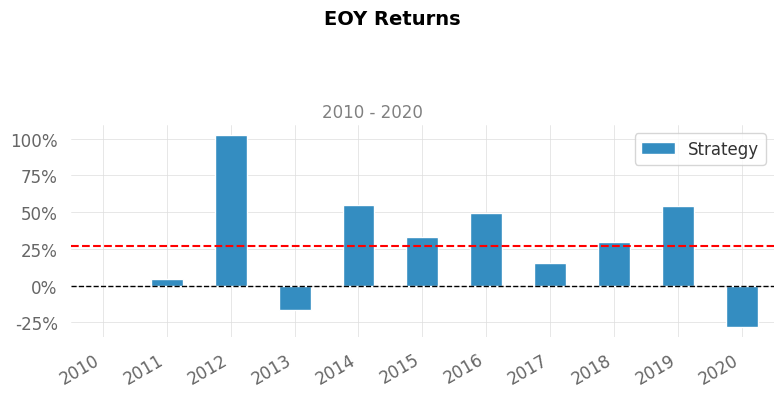

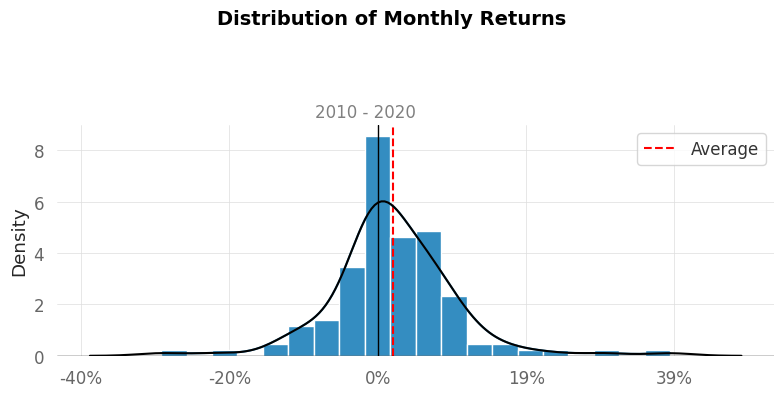

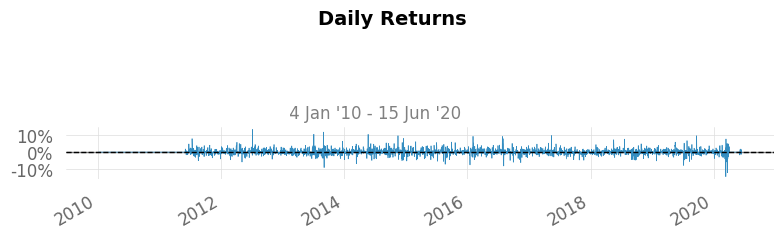

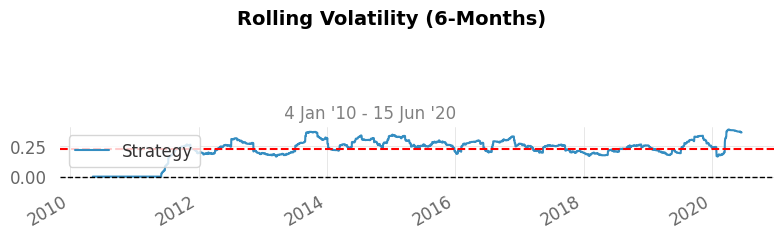

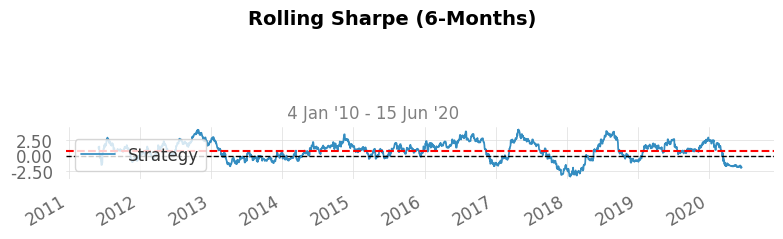

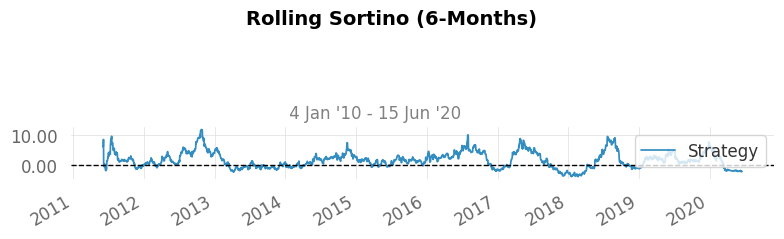

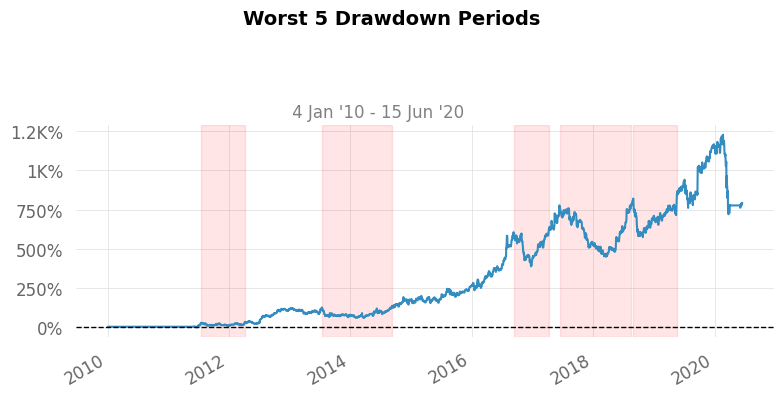

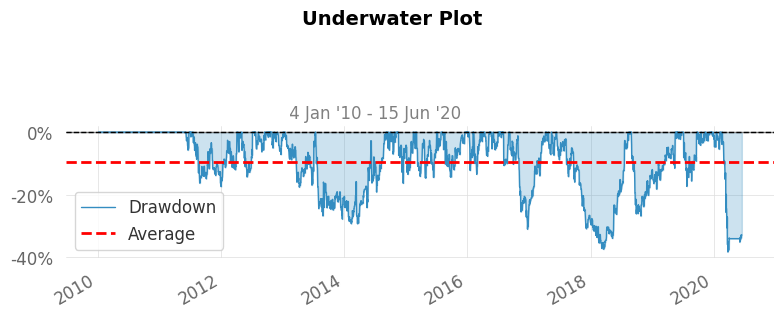

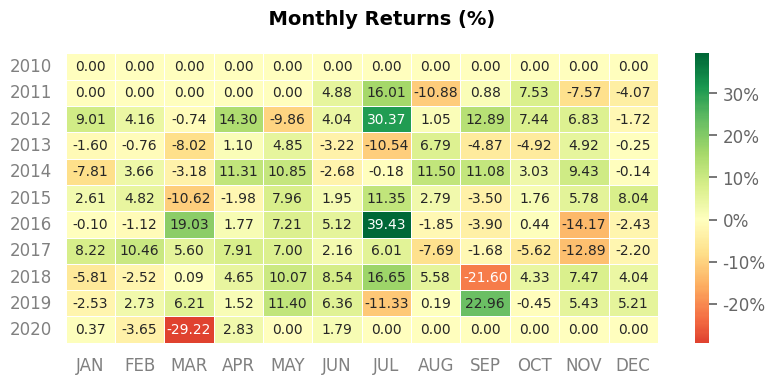

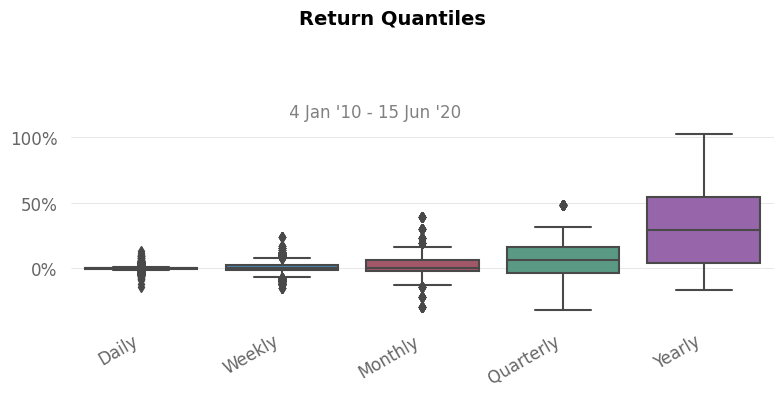

In [341]:
strat=results[-1]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.index = returns.index.tz_convert(None)
qs.reports.full(returns)

In [342]:
qs.reports.html(returns, output='quantstats-tearsheet.html', title='Mean Variance Optimization')